In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import fmin_slsqp


In [3]:
def vehicle_model_np(state, control):
    x, y, theta, v = state
    delta, a = control

    dx = v * np.cos(theta)
    dy = v * np.sin(theta)
    dtheta = (v * np.tan(delta)) / 2.5
    dv = a

    return np.array([dx, dy, dtheta, dv])

def rk2_np(state, control, dt=0.2):
    k1 = dt * vehicle_model_np(state, control)
    k2 = dt * vehicle_model_np(state + 0.5 * k1, control)
    return state + k2

def cost_function(state,control):
    y = state[1]
    delta = control[0]
    a = control[1]

    cost = 0.0
    cost += y**2 # Penalize deviation from y = 0 : Tracking error
    cost += 0.1 * delta**2 + 0.1 * a**2 # Penalize steering and acceleration : Control effort
    return cost

def total_cost(u_flat, x0, N):
    u_seq = u_flat.reshape(N, 2)
    x = x0.copy()
    cost = 0.0
    for k in range(N):
        u = u_seq[k]
        cost += cost_function(x, u)
        x = rk2_np(x, u)
    return cost   

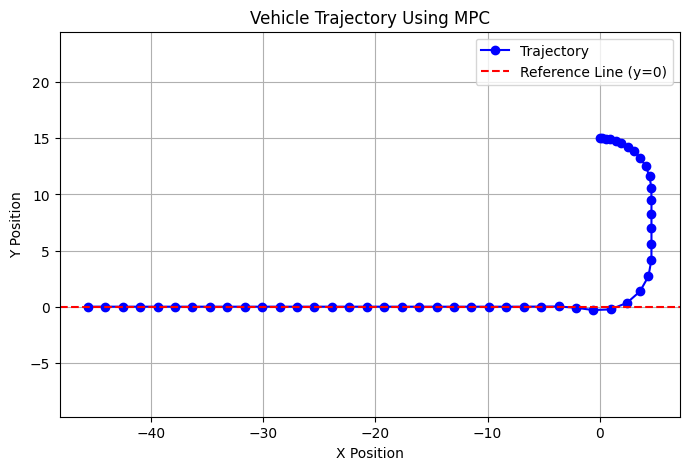

In [20]:
no_states = 4
no_inputs = 2
prediction_horizon = 10
dt = 0.2


u = np.zeros((prediction_horizon, no_inputs)) 
x = np.array([0.0, 15.0, 0.0, 1.0])  # Initial state: [x, y, theta, v]    


traj_x = [x[0]]
traj_y = [x[1]]

N = prediction_horizon
for i in range(50):  # Simulate for 250 iterations
    u_flat = u.flatten()  # shape (N*2,)
    
    # Optimize
    result = fmin_slsqp(
        func=total_cost,
        x0=u_flat,
        args=(x, N),
        iter=10,
        disp=False,
        bounds=[(-0.5, 0.5), (-2.0, 2.0)] * N
    )
    
    u_opt = result.reshape(N, 2)
    
    # Apply first control input

    # Clip controls
   
    u0 = u_opt[0]
    x = rk2_np(x, u0, dt)
    
    # Shift control horizon
    u[:-1] = u_opt[1:]
    u[-1] = u[-2]  # Repeat last action
    
    # Save trajectory
    traj_x.append(x[0])
    traj_y.append(x[1])

plt.figure(figsize=(8, 5))
plt.plot(traj_x, traj_y, 'bo-', label="Trajectory")
plt.axhline(y=0, color='r', linestyle='--', label="Reference Line (y=0)")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Vehicle Trajectory Using MPC")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()




In [ ]:
# Bound on acceleration .. - val < a < val